In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from keras_unet.model_utils import normalize_MRIvolume
from keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import bce_dice_loss

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


In [4]:
def read_in_images(lung_path,msk_path,img_path):
    Images = []
    Masks = []
  
    for img in img_path:
        temp_img = lung_path+'/2d_images/' +img
        temp_img = cv2.imread(temp_img)
        Images.append(temp_img)

    for msk in msk_path:
        temp_msk = lung_path+ '/2d_masks/'+msk
        temp_msk = cv2.imread(temp_msk)
        Masks.append(temp_msk)

    return Images, Masks

In [14]:
#load dataset
lung_path = 'Data/lung-masks'

img_path = lung_path + '/2d_images/'
msk_path = lung_path + '/2d_masks/'

imgs = os.listdir(img_path)
msks = os.listdir(msk_path)
imgs = sorted(imgs)
msks = sorted(msks)
images,masks = read_in_images(lung_path,msks,imgs)

In [15]:
msks == imgs

True

In [16]:
for i in range(0,len(masks)):
    m = masks[i]
    m = m[:,:,0]
    m.reshape(m.shape[0],m.shape[1])
    m = cv2.resize(m,(256,256))
    masks[i] = m
    #images
    im = images[i]
    images[i] = cv2.resize(im,(256,256))

#make Arrays 
images = np.asarray(images)
masks = np.asarray(masks)
masks = masks / 255
#masks = masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
    

#split the data
img_overall_train, img_test, mask_overall_train, mask_test = train_test_split(images, masks, test_size=0.16667, random_state=42)
img_train, img_val, mask_train, mask_val = train_test_split(img_overall_train, mask_overall_train, test_size = 0.166667, random_state = 32)

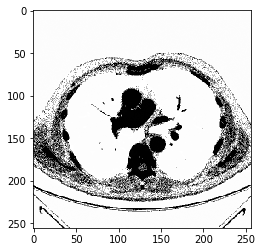

In [17]:
plt.imshow(images[0])

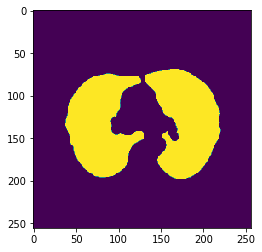

In [18]:
plt.imshow(masks[0])

In [19]:
img_train.shape

(184, 256, 256, 3)

In [20]:
mask_train.shape

(184, 256, 256)

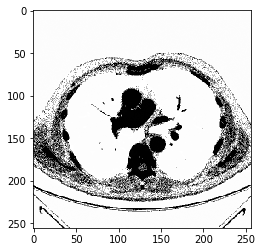

In [21]:
plt.imshow(images[0])

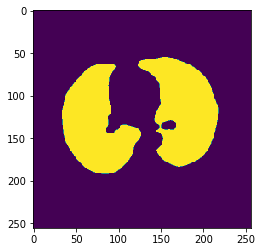

In [22]:
plt.imshow(mask_test[0])

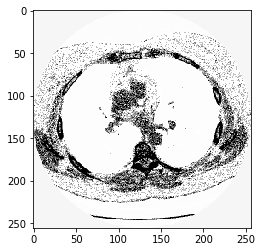

In [23]:
plt.imshow(img_test[0])

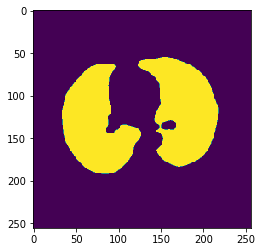

In [24]:
plt.imshow(mask_test[0])

In [119]:
#loaded_model = load_model('evaluations/final_models/3search_best_600_LR001_BASIC_LUNG_UNET.h5',custom_objects={'iou':iou, 'iou_thresholded':iou_thresholded,'bce_dice_loss':bce_dice_loss})
loaded_model = load_model('evaluations/final_models/final_600_LR001_BASIC_LUNG_UNET.h5',custom_objects={'iou':iou, 'iou_thresholded':iou_thresholded,'bce_dice_loss':bce_dice_loss})

In [120]:
preds = loaded_model.predict(img_test)

In [121]:
mask_test = mask_test.reshape(mask_test.shape[0],mask_test.shape[1],mask_test.shape[2])
#preds = preds.reshape(preds.shape[0],preds.shape[1],preds.shape[2])

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'reshape'

In [ ]:
preds = np.asarray(preds)

In [ ]:
masks = masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2])
preds = preds.reshape(preds.shape[0],preds.shape[1],preds.shape[2])

In [71]:
def plot_figures(img_path, msk_path):
    rows,cols=3,3
    fig=plt.figure(figsize=(10,10))
    for i in range(1,rows*cols+1):
        fig.add_subplot(rows,cols,i)
        i_path=img_path[i]
        m_path=msk_path[i]
        img = i_path
        msk = m_path
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.imshow(msk,alpha=0.4)
    plt.show()

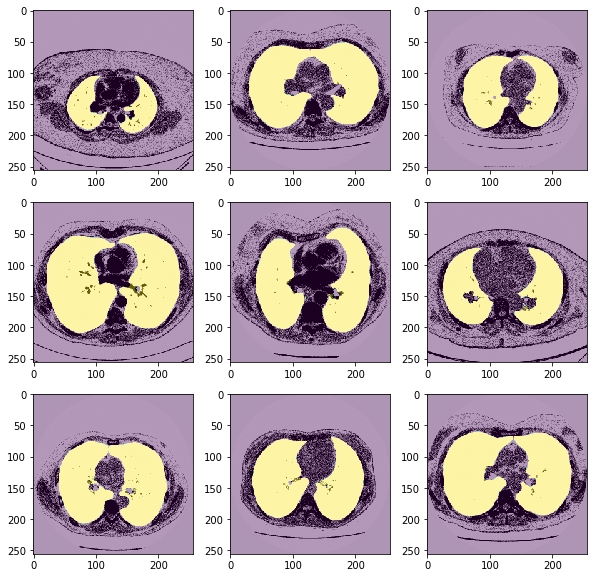

In [72]:
plot_figures(img_test,mask_test)

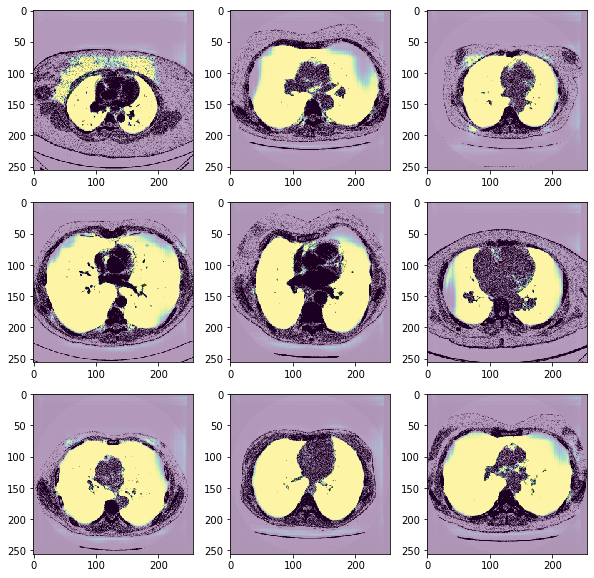

In [73]:
plot_figures(img_test,preds)

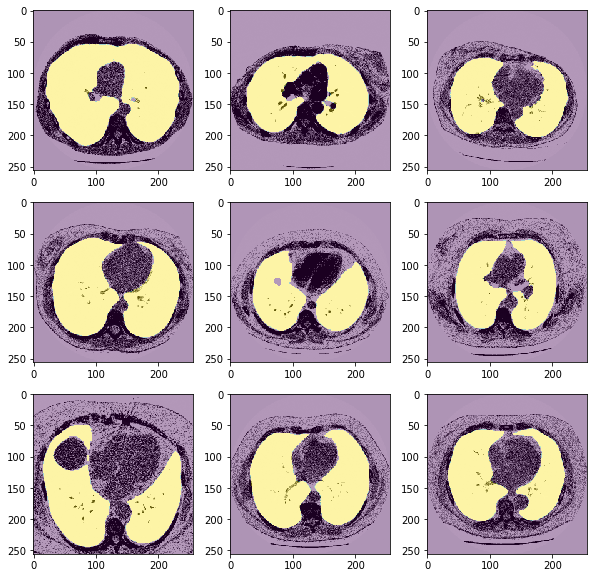

In [74]:
plot_figures(images,masks)

In [75]:
images.shape

(267, 256, 256, 3)

In [76]:
masks.shape

(267, 256, 256)

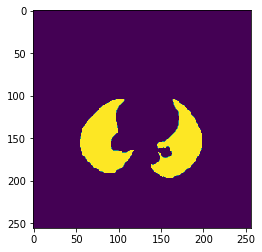

In [77]:
plt.imshow(mask_test[1])

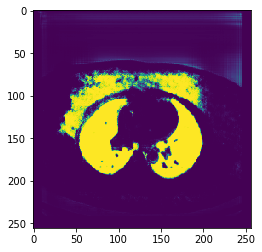

In [78]:
plt.imshow(preds[1])

In [79]:
mask_test.shape

TensorShape([45, 256, 256])

In [80]:
preds.shape

(45, 256, 256)

In [ ]:
preds = np.asarray(preds)

In [ ]:
preds = preds.reshape(preds.shape[0],preds.shape[1],preds.shape[1])

In [ ]:
preds = tf.cast(preds, 'float32', name=None
)
mask_test = tf.cast(mask_test,'float32')
iou(preds,mask_test)

In [ ]:
iou_thresholded(preds,mask_test)

In [ ]:
mse = (np.square(preds - mask_test)).mean(axis=None)
mse

In [ ]:
mae = np.abs(preds-mask_test).mean(axis=None)
mae

In [88]:
cl = 4
for i in enumerate(cl):
    print(i)

TypeError: 'int' object is not iterable

In [89]:
def pixelwise_accuracy(truth, prediction):
    num_images = truth.shape[0]
    sum_n_ii = 0
    sum_t_i = 0
    
    for i in range(0, num_images):
        curr_eval_mask = truth[i, :, :]
        curr_gt_mask = prediction[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
        
    if (sum_t_i == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n_ii / sum_t_i

    return pixel_accuracy

In [90]:
l = preds[2,:,:]
l.shape
l.shape[0]*l.shape[1]
256*256

65536

In [91]:
l[2,48]

<tf.Tensor: shape=(), dtype=float32, numpy=0.020721316>

In [122]:
#accuracy is defined as the correct/total 
def pixelwise_accuracy(truth, prediction):
    #number of images to loop through
    num_images = truth.shape[0]
    #correct and total for final division
    sum_correct = 0
    sum_total = 0
    
    for i in range(0,num_images):
        #evaluate current mask 
        eval_prediction = prediction[i,:,:]
        eval_test = truth[i,:,:]
        #add up similarities and total values 
        sum_total += eval_test.shape[0] *eval_test.shape[1]
        for w in range(0,eval_test.shape[0]):
            for h in range(0,eval_test.shape[1]):
                if (eval_prediction[w,h] == eval_test[w,h]):
                    sum_correct += 1
    return sum_correct/sum_total
        
    
    

In [123]:
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [116]:
pixelwise_accuracy(mask_test,preds)

0.0

In [124]:
#threshold the pixelwise accuracy value using two functions we already have 
def thresholded_pixelwise_accuracy(truth, prediction):
    new_preds = threshold_binarize(prediction,0.5)
    return pixelwise_accuracy(truth, new_preds)

In [125]:
thresholded_pixelwise_accuracy(mask_test,preds)

0.9555250379774306

In [92]:
#precision is known as the TP/(TP+FP)
#this shows the purity 

def thresholded_precision(truth,prediction):
    #binarize threshold
    new_preds = threshold_binarize(prediction, 0.5)
    #starting loop and shape variables 
    num_images = truth.shape[0]
    num_TP = 0
    num_predictedPositives = 0 
    
    #loop through all images 
    for i in range(0,num_images):
        #evaluate current mask 
        eval_prediction = new_preds[i,:,:]
        eval_test = truth[i,:,:]
        #find total positive guesses 
        for w in range(0,eval_test.shape[0]):
            for h in range(0,eval_test.shape[1]):
                if (eval_prediction[w,h] == 1):
                    num_predictedPositives +=1
                    if (eval_test[w,h] == 1):
                        num_TP +=1 
    
    if (num_predictedPositives ==0):
        return 0 
    else:
        return num_TP/num_predictedPositives 
        

In [93]:
thresholded_precision(mask_test,preds)

0.9092539978197612

In [94]:
#TP / TP + FN 
#recall shows the completeness 
def thresholded_recall(truth,prediction):
    #binarize threshold
    new_preds = threshold_binarize(prediction, 0.5)
    #starting loop and shape variables 
    num_images = truth.shape[0]
    num_TP = 0
    num_allPositives = 0 
    
    #loop through all images 
    for i in range(0,num_images):
        #evaluate current mask 
        eval_prediction = new_preds[i,:,:]
        eval_test = truth[i,:,:]
        #find total positive guesses 
        for w in range(0,eval_test.shape[0]):
            for h in range(0,eval_test.shape[1]):
                if (eval_test[w,h] == 1):
                    num_allPositives +=1
                    if (eval_prediction[w,h] == 1):
                        num_TP +=1 
    
    if (num_allPositives ==0):
        return 0 
    else:
        return num_TP/num_allPositives 
    

In [95]:
thresholded_recall(mask_test,preds)

0.914888563569075

In [ ]:
def dice_coefficient(truth, prediction):
    

In [104]:
np.mean(bce_dice_loss(preds,mask_test))

0.87699044

In [267]:
l = mask_test[1]
m = preds[1]

In [111]:
from keras import backend as K

In [112]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [113]:
dice_coef(mask_test,preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9612097>

In [ ]:
#Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images 
